In [8]:
import torch
import numpy as np
from torch import Tensor
import pandas as pd
from pathlib import Path
from labproject.plotting import  place_violin

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import fontManager
from matplotlib import rc_file
rc_file("../../matplotlibrc")

from labproject.metrics.MMD_torch import *
from labproject.metrics.sliced_wasserstein import sliced_wasserstein_distance
from labproject.metrics.c2st import *
from labproject.metrics.gaussian_squared_wasserstein import gaussian_squared_w2_distance
from labproject.plotting import tiled_ticks, get_lims
from labproject.plotting import cm2inch
from labproject import plotting

import warnings
warnings.filterwarnings("ignore")

fontManager.addfont(Path(".").absolute().parent.parent / "fonts/arial.ttf")
matplotlib.rc("font", **{"family": "sans-serif", "sans-serif": "Arial"})

In [ ]:
from labprojec

In [58]:
metric_colors = dict(SW="#7E2320", C2ST="#345657", MMD="#8B712C", FID="#648359")

In [2]:
# CXR embeddings
cxr1 = torch.load('../../data/cxr/encs_real.pt')
cxr2 = torch.load('../../data/cxr/encs_fake_pggan.pt')
cxr3 = torch.load('../../data/cxr/encs_fake_stable_diffusion.pt')

# CXR real images
cxr1_real_path = Path('../../data/images')
cxr2_sd_path = Path('../../data/output')
cxr3_gan_path = Path('../../data/generated_samples')

# DDM
ddm1 = torch.load('../../data/ddm/real_data.pt')                   
ddm2 = torch.load('../../data/ddm/generated_data.pt')
ddm3 = torch.load('../../data/ddm/generated_data2.pt')#torch.load('../../data/ddm/gaussian_data.pt')

In [17]:

class Metric:
    def __init__(self, name: str, func: callable, **kwargs):
        self.name = name
        self.func = func
        self.kwargs = kwargs

    def __call__(self, x: Tensor, y: Tensor) -> Tensor:
        return self.func(x, y, **self.kwargs)
    

class DistComp:
    def __init__(self, dataset_id1: Tensor, dataset_id2: Tensor, metric: Metric, 
                 n_perms: int = 100, perm_size=1000, descr=""):
        self.dataset_id1 = dataset_id1
        self.dataset_id2 = dataset_id2
        self.metric = metric
        self.n_perms = n_perms
        self.perm_size = perm_size
        self.descr = descr

        columns = [metric.name]
        self.results_df = pd.DataFrame(np.nan, index=range(self.n_perms), columns=columns)

    def run_experiment(self, seed=42):
        for i in range(self.n_perms):
            dataset_id2_perm = self.dataset_id2[torch.randperm(len(self.dataset_id2))[:self.perm_size]]
            dataset_id1_perm = self.dataset_id1[torch.randperm(len(self.dataset_id1))[:self.perm_size]]
            
            metric = self.metric(dataset_id1_perm, dataset_id2_perm)
            
            if isinstance(metric, torch.Tensor):
                metric = metric.item()
            self.results_df.loc[i, self.metric.name] = metric
        assert not np.any(np.isnan(self.results_df.values))
    
    def reformat_df(self, data):
        """
        reformat the results_df to work with seaborn plot expectations.
        """
        metric = [column_name for _, row in data.iterrows() for column_name, _ in row.items()]
        split_ind = [i for i, _ in data.iterrows() for _ in range(len(data.columns))]
        distance = [value for _, row in data.iterrows() for _, value in row.items()]

        return pd.DataFrame({"metric": metric, "distance": distance, "split_ind": split_ind})
    
    def __repr__(self):
        return f"{self.__class__.__name__}\nDescription:{self.descr}"

In [54]:
def generate_palette(hex_color, n_colors=5, saturation="light"):
    if saturation == "light":
        palette = sns.light_palette(hex_color, n_colors=n_colors, as_cmap=False)
    elif saturation == "dark":
        palette = sns.dark_palette(hex_color, n_colors=n_colors, as_cmap=False)
    return palette

color_dict = {"SW": "#cc241d", "MMD": "#eebd35", "C2ST": "#458588", "FID": "#8ec07c"}

In [19]:
datasets = {
    "ddm": {
        "metrics": [
            Metric('SW', sliced_wasserstein_distance),
            Metric('C2ST', c2st_nn),
            Metric('MMD', compute_rbf_mmd, bandwidth=0.5),
            # Metric("FID", gaussian_squared_w2_distance)
        ],
        "comparisons":[
            (ddm1, ddm1),
            (ddm1, ddm2),
            (ddm1, ddm3),
            (ddm2, ddm3),
        ],
        "descr": [
            "real vs real",
            "real vs DDM1", 
            "real vs DDM2", 
            "DDM1 vs DDM2",
        ],
        "kwargs":{
            "n_perms": 10,
            "perm_size": 300
        }
    },
    "cxr": {
        "metrics": [
            Metric('SW', sliced_wasserstein_distance),
            Metric('C2ST', c2st_nn),
            Metric('MMD', compute_rbf_mmd, bandwidth=50.0),
            Metric("FID", gaussian_squared_w2_distance)
        ],
        "comparisons":[
            (cxr1, cxr1),
            (cxr1, cxr2),
            (cxr1, cxr3),
            (cxr2, cxr3),
        ],
        "descr": [
            "real vs real",
            "real vs PGGAN", 
            "real vs SD",
            "PGGAN vs SD",
        ],
        "kwargs":{
            "n_perms": 10,
            "perm_size": 1000
        },
        "paths": 
            {
                "real": cxr1_real_path,
                "SD": cxr2_sd_path,
                "PGGAN": cxr3_gan_path,
            }

    }
}  

In [20]:
torch.manual_seed(42)

experiments = {}
for dataset_id in datasets:
   n_metrics = len(datasets[dataset_id]["metrics"])
   n_comparisons = len(datasets[dataset_id]["comparisons"])
   n_perms = datasets[dataset_id]["kwargs"]["n_perms"]
   perm_size = datasets[dataset_id]["kwargs"]["perm_size"]
   experiments[dataset_id] = np.zeros([n_metrics, n_comparisons, n_perms])

   for i, metric in enumerate(datasets[dataset_id]["metrics"]):
      for j, (comp, descr) in enumerate(zip(datasets[dataset_id]["comparisons"], datasets[dataset_id]["descr"])):
            exp = DistComp(comp[0], comp[1], metric, n_perms=n_perms, perm_size=perm_size, descr=descr)
            exp.run_experiment()
            experiments[dataset_id][i, j, :] = exp.results_df.to_numpy().flatten()


-----------------------------------------------------------

## DDM plots 

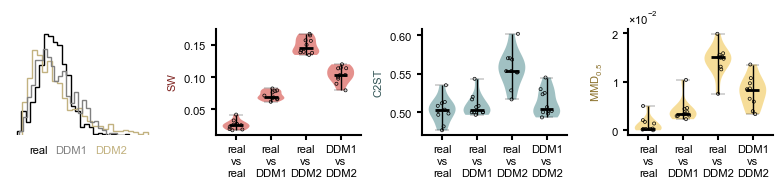

In [69]:
fig, axes = plt.subplots(1, 4, figsize=[cm2inch(25.), cm2inch(3.5)])

# Set the formatter
formatter = ticker.ScalarFormatter(useMathText=True) # Use mathematical text for scientific notation
formatter.set_scientific(True) # Enable scientific notation
formatter.set_powerlimits((-1,1)) # This will force scientific notation

dataset_id = 'ddm'
experiment = experiments[dataset_id]


ax = axes[0]
_, bins, _ = ax.hist(ddm1.flatten(), bins=25, histtype='step', lw=1, label='real', color="k", zorder=0, density=True)
ax.hist(ddm2.flatten(), bins=25, histtype='step', lw=1, label='DDM1', color="0.5", zorder=10, density=True)
ax.hist(ddm3.flatten(), bins=25, histtype='step', lw=1, label='DDM2', color="#C2B280", zorder=5, density=True)
ax.annotate("real", (0.2, -0.1), xycoords="axes fraction", color="k", ha='center', va='top', fontweight='bold')
ax.annotate("DDM1", (0.425, -0.1), xycoords="axes fraction", color="0.5", ha='center', va='top', fontweight='bold')
ax.annotate("DDM2", (0.7, -0.1), xycoords="axes fraction", color="#C2B280", ha='center', va='top', fontweight='bold')


for j, metric in enumerate(datasets[dataset_id]["metrics"]):
    for k, comparison in enumerate(datasets[dataset_id]["comparisons"]):
        X = tiled_ticks(0, 2, n_major_ticks=1, n_minor_ticks=len(datasets[dataset_id]["comparisons"]), offset=0.175)
        x, Y = X[0][k], experiment[j, k]
        ax = axes[j + 1]
        body_colors = generate_palette(color_dict[metric.name], n_colors=n_comparisons)
        place_violin(ax, x, Y, 
                        scatter_face_color="none",
                    scatter_edge_color="k",
                    scatter_lw=0.5,
                    scatter_radius=5,
                    scatter_alpha=1,
                    scatter_width=0.5,
                    scatter=True,
                    scatter_zorder=3,
                    width=0.09, 
                    median_color='k', #color_dict[metrics_names[i]],
                    median_bar_length=0.5, 
                    median_lw=2, 
                    whisker_color='k', #color_dict[metrics_names[i]],
                    whisker_alpha=1, 
                    whisker_lw=1,
                    median_alpha=1,
                    #    body_face_color=body_colors[k])
                    body_face_color=color_dict[metric.name],
                    body_edge_color="none",
                    body_alpha=0.5)

# # cosmetics
ylabels = ["", "SW", "C2ST", "MMD", "FID"]
ylabels_with_subscript = {ylabel: ylabel for ylabel in ylabels}
ylabels_with_subscript["MMD"] = "MMD$_{0.5}$"

for column, ax in enumerate(axes):
        
    # remove first axis spines
    if column == 0:
        plotting.rm_spines(ax)

    else:
        ax.set_ylabel(ylabels_with_subscript[ylabels[column]],
                      color=metric_colors[ylabels[column]])

        ax.yaxis.set_major_formatter(formatter)
        
        xticklabel = [xtl.split(" vs ") for xtl in datasets[dataset_id]["descr"]]
        xticklabel = ["\nvs\n".join(xtl) for xtl in xticklabel] 
        ax.set_xticks(X[0], xticklabel, rotation=0)
        

    ax.patch.set_alpha(0)

plt.subplots_adjust(wspace=0.425)

plt.savefig("application_01_ddm.pdf", bbox_inches="tight", transparent=True)

-----------------------------------------------------------

## XRay plots 

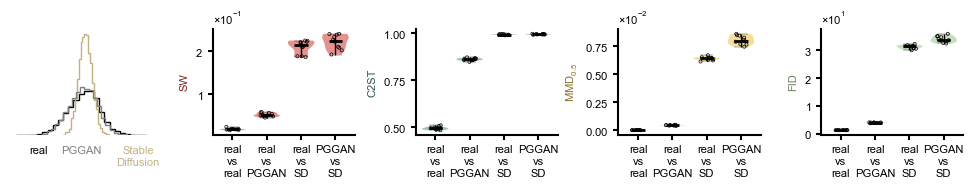

In [66]:
fig, axes = plt.subplots(1, 5, figsize=[cm2inch(25. + 6.25), cm2inch(3.5)])

# Set the formatter
formatter = ticker.ScalarFormatter(useMathText=True) # Use mathematical text for scientific notation
formatter.set_scientific(True) # Enable scientific notation
formatter.set_powerlimits((-1,1)) # This will force scientific notation

dataset_id = 'cxr'
experiment = experiments[dataset_id]


ax = axes[0]
_, bins, _ = ax.hist(cxr1.mean(axis=1), bins=25, histtype='step', lw=1, label='real', color="k", zorder=0, density=True)
ax.hist(cxr2.mean(axis=1), bins=25, histtype='step', lw=1, label='PGGAN', color="0.5", zorder=10, density=True)
ax.hist(cxr3.mean(axis=1), bins=25, histtype='step', lw=1, label='Stable Diffusion', color="#C2B280", zorder=5, density=True)
ax.annotate("real", (0.2, -0.1), xycoords="axes fraction", color="k", ha='center', va='top', fontweight='bold')
ax.annotate("PGGAN", (0.5, -0.1), xycoords="axes fraction", color="0.5", ha='center', va='top', fontweight='bold')
ax.annotate("Stable\nDiffusion", (0.9, -0.1), xycoords="axes fraction", color="#C2B280", ha='center', va='top', fontweight='bold')


for j, metric in enumerate(datasets[dataset_id]["metrics"]):
    for k, comparison in enumerate(datasets[dataset_id]["comparisons"]):
        X = tiled_ticks(0, 2, n_major_ticks=1, n_minor_ticks=len(datasets[dataset_id]["comparisons"]), offset=0.175)
        x, Y = X[0][k], experiment[j, k]
        ax = axes[j + 1]
        body_colors = generate_palette(color_dict[metric.name], n_colors=n_comparisons)
        place_violin(ax, x, Y, 
                        scatter_face_color="none",
                    scatter_edge_color="k",
                    scatter_lw=0.5,
                    scatter_radius=5,
                    scatter_alpha=1,
                    scatter_width=0.5,
                    scatter=True,
                    scatter_zorder=3,
                    width=0.09, 
                    median_color='k', #color_dict[metrics_names[i]],
                    median_bar_length=0.5, 
                    median_lw=2, 
                    whisker_color='k', #color_dict[metrics_names[i]],
                    whisker_alpha=1, 
                    whisker_lw=1,
                    median_alpha=1,
                    #    body_face_color=body_colors[k])
                    body_face_color=color_dict[metric.name],
                    body_edge_color="none",
                    body_alpha=0.5)

# # cosmetics
ylabels = ["", "SW", "C2ST", "MMD", "FID"]
ylabels_with_subscript = {ylabel: ylabel for ylabel in ylabels}
ylabels_with_subscript["MMD"] = "MMD$_{0.5}$"

for column, ax in enumerate(axes):
        
    # remove first axis spines
    if column == 0:
        plotting.rm_spines(ax)

    else:
        ax.set_ylabel(ylabels_with_subscript[ylabels[column]], color=metric_colors[ylabels[column]])
        ax.yaxis.set_major_formatter(formatter)
        
        xticklabel = [xtl.split(" vs ") for xtl in datasets[dataset_id]["descr"]]
        xticklabel = ["\nvs\n".join(xtl) for xtl in xticklabel] 
        ax.set_xticks(X[0], xticklabel, rotation=0)

    if column == 2:
        ax.set_yticks([0.5, 0.75, 1.0])

    ax.patch.set_alpha(0)

plt.subplots_adjust(wspace=0.425)
plt.savefig("application_01_cxr.pdf", bbox_inches="tight", transparent=True)

## Without embedding-mean distributions

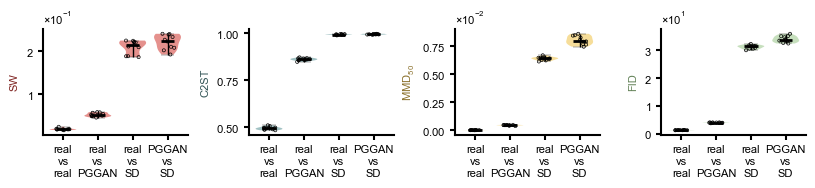

In [70]:
fig, axes = plt.subplots(1, 4, figsize=[cm2inch(25.), cm2inch(3.5)])

# Set the formatter
formatter = ticker.ScalarFormatter(useMathText=True) # Use mathematical text for scientific notation
formatter.set_scientific(True) # Enable scientific notation
formatter.set_powerlimits((-1,1)) # This will force scientific notation

dataset_id = 'cxr'
experiment = experiments[dataset_id]


# ax = axes[0]
# _, bins, _ = ax.hist(cxr1.mean(axis=1), bins=25, histtype='step', lw=1, label='real', color="k", zorder=0, density=True)
# ax.hist(cxr2.mean(axis=1), bins=25, histtype='step', lw=1, label='PGGAN', color="0.5", zorder=10, density=True)
# ax.hist(cxr3.mean(axis=1), bins=25, histtype='step', lw=1, label='Stable Diffusion', color="#C2B280", zorder=5, density=True)
# ax.annotate("real", (0.2, -0.1), xycoords="axes fraction", color="k", ha='center', va='top', fontweight='bold')
# ax.annotate("PGGAN", (0.5, -0.1), xycoords="axes fraction", color="0.5", ha='center', va='top', fontweight='bold')
# ax.annotate("Stable\nDiffusion", (0.9, -0.1), xycoords="axes fraction", color="#C2B280", ha='center', va='top', fontweight='bold')


for j, metric in enumerate(datasets[dataset_id]["metrics"]):
    for k, comparison in enumerate(datasets[dataset_id]["comparisons"]):
        X = tiled_ticks(0, 2, n_major_ticks=1, n_minor_ticks=len(datasets[dataset_id]["comparisons"]), offset=0.175)
        x, Y = X[0][k], experiment[j, k]
        ax = axes[j]
        body_colors = generate_palette(color_dict[metric.name], n_colors=n_comparisons)
        place_violin(ax, x, Y, 
                        scatter_face_color="none",
                    scatter_edge_color="k",
                    scatter_lw=0.5,
                    scatter_radius=5,
                    scatter_alpha=1,
                    scatter_width=0.5,
                    scatter=True,
                    scatter_zorder=3,
                    width=0.09, 
                    median_color='k', #color_dict[metrics_names[i]],
                    median_bar_length=0.5, 
                    median_lw=2, 
                    whisker_color='k', #color_dict[metrics_names[i]],
                    whisker_alpha=1, 
                    whisker_lw=1,
                    median_alpha=1,
                    #    body_face_color=body_colors[k])
                    body_face_color=color_dict[metric.name],
                    body_edge_color="none",
                    body_alpha=0.5)

# # cosmetics
ylabels = ["SW", "C2ST", "MMD", "FID"]
ylabels_with_subscript = {ylabel: ylabel for ylabel in ylabels}
ylabels_with_subscript["MMD"] = "MMD$_{50}$"

for column, ax in enumerate(axes):
        
    # remove first axis spines
    # if column == 0:
    #     plotting.rm_spines(ax)

    # else:
    ax.set_ylabel(ylabels_with_subscript[ylabels[column]], color=metric_colors[ylabels[column]])
    ax.yaxis.set_major_formatter(formatter)
    
    xticklabel = [xtl.split(" vs ") for xtl in datasets[dataset_id]["descr"]]
    xticklabel = ["\nvs\n".join(xtl) for xtl in xticklabel] 
    ax.set_xticks(X[0], xticklabel, rotation=0)

    if column == 1:
        ax.set_yticks([0.5, 0.75, 1.0])

    ax.patch.set_alpha(0)

plt.subplots_adjust(wspace=0.425)
plt.savefig("application_01_cxr_wo_dist.pdf", bbox_inches="tight", transparent=True)

## Example images

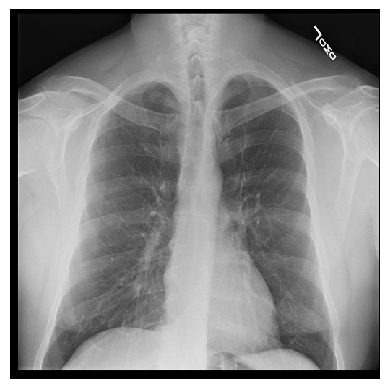

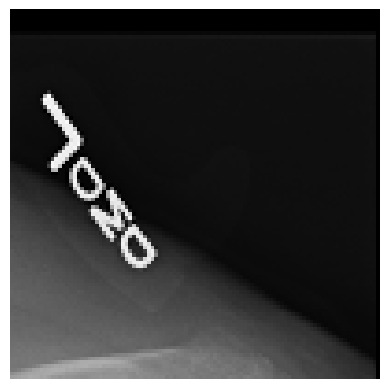

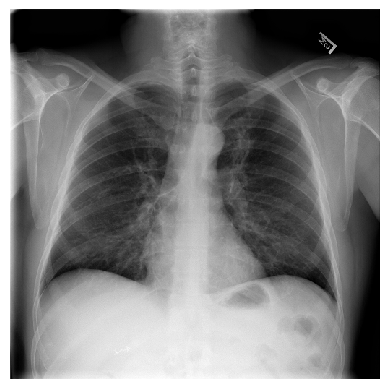

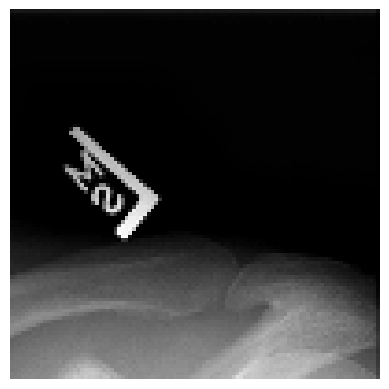

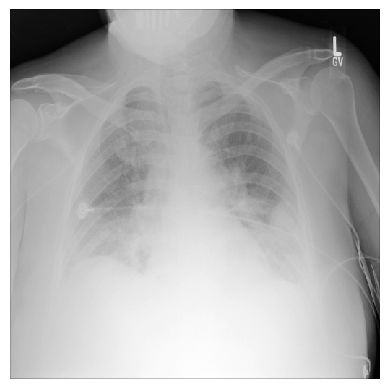

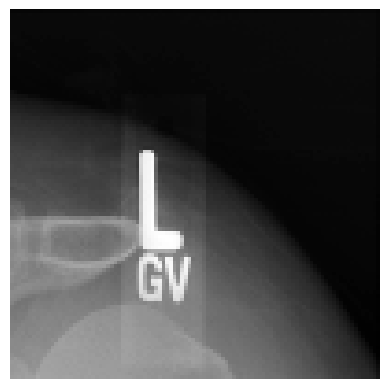

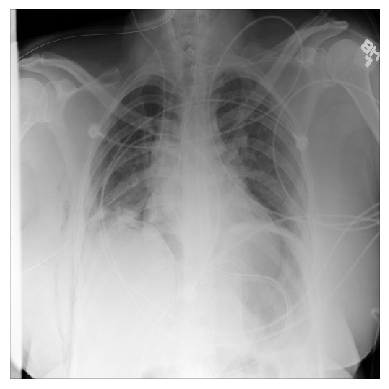

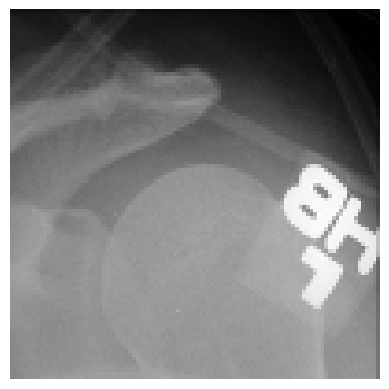

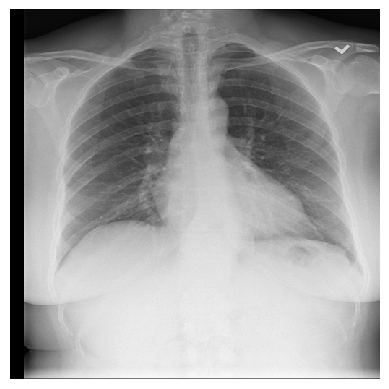

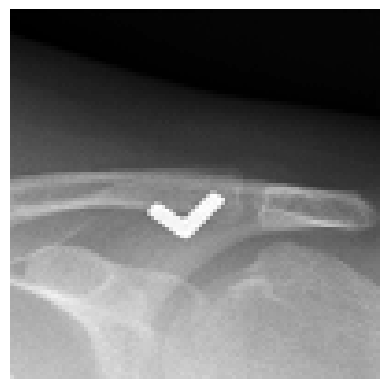

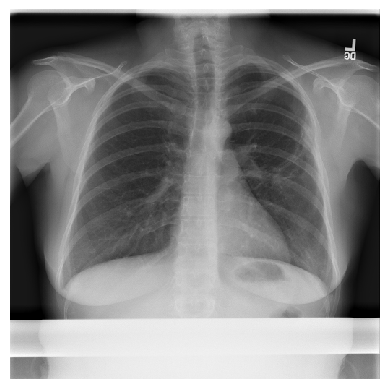

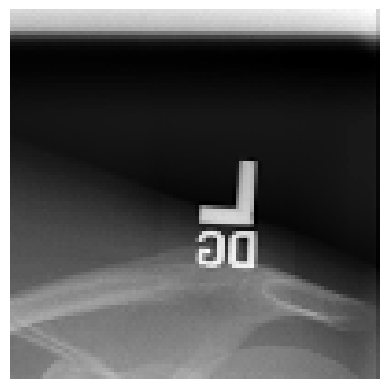

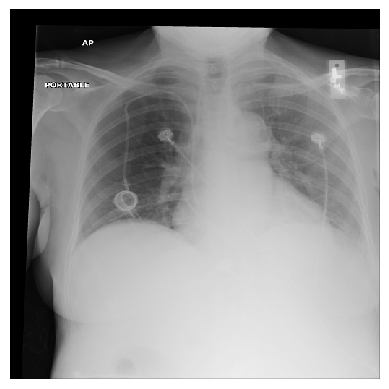

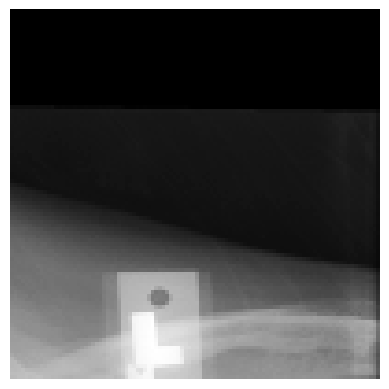

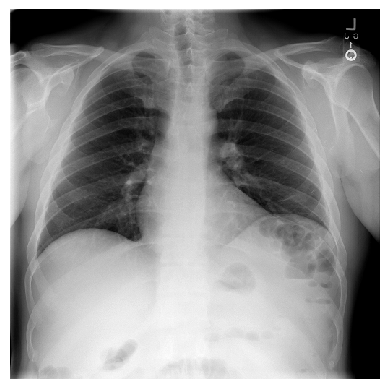

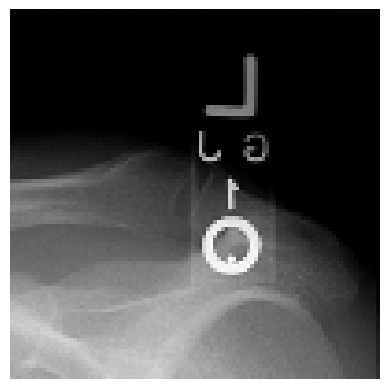

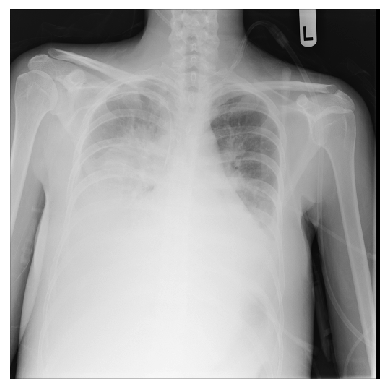

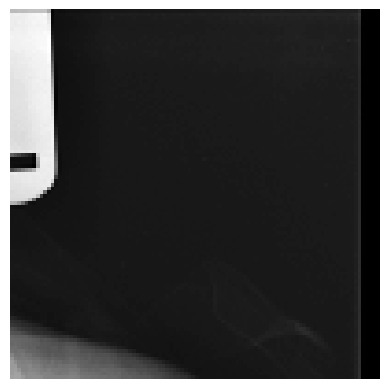

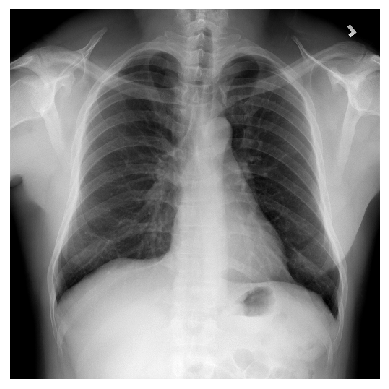

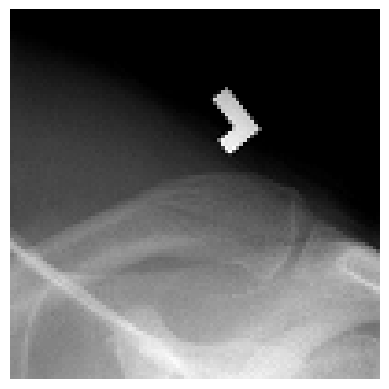

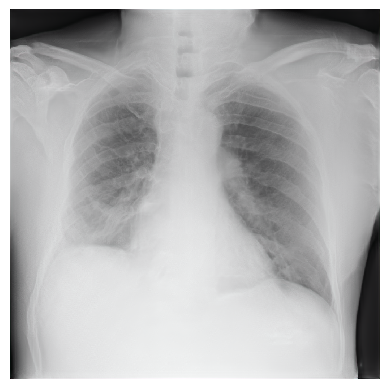

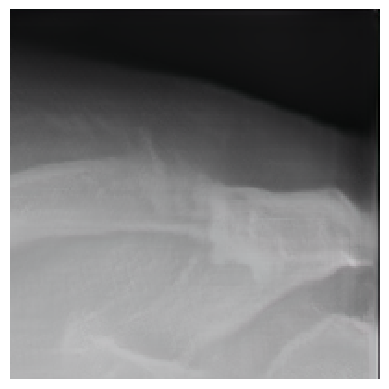

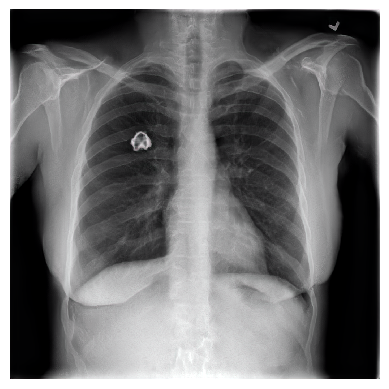

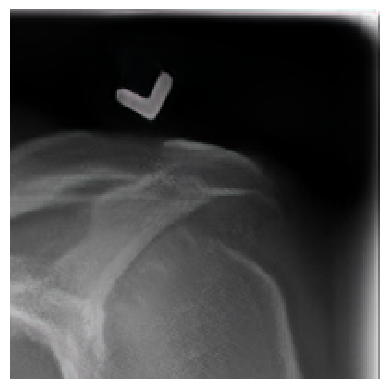

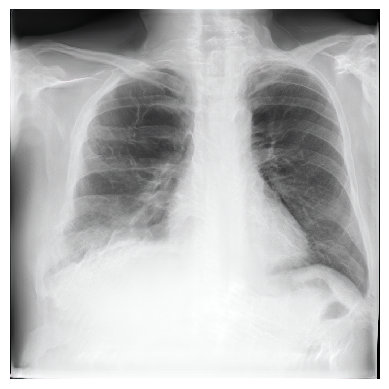

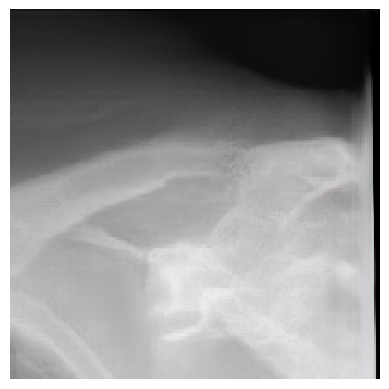

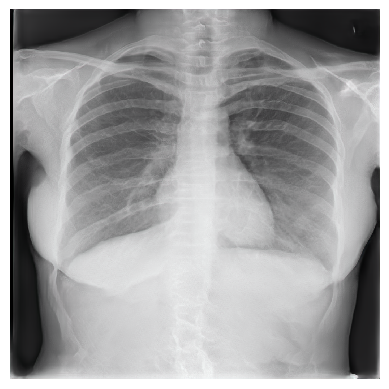

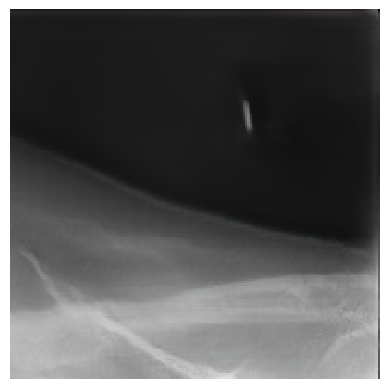

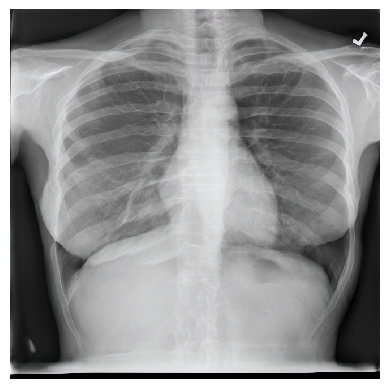

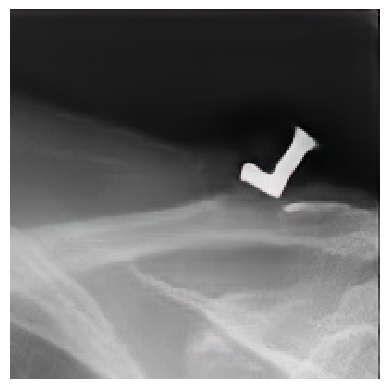

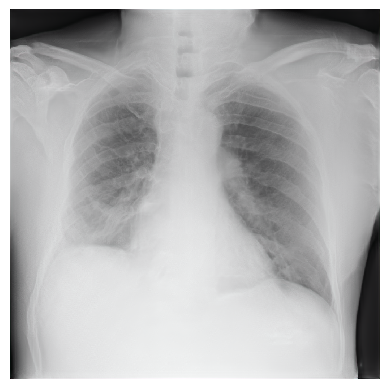

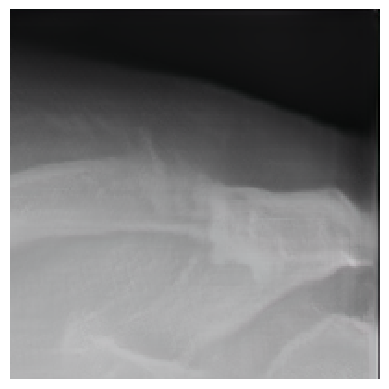

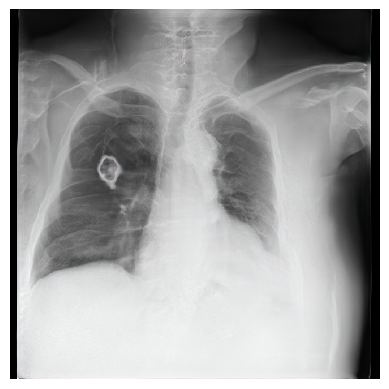

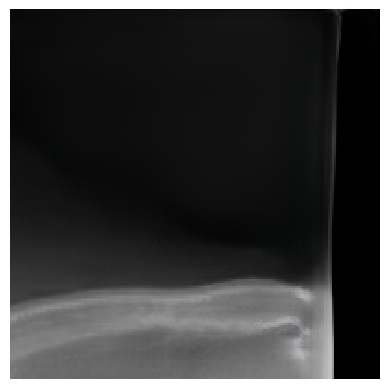

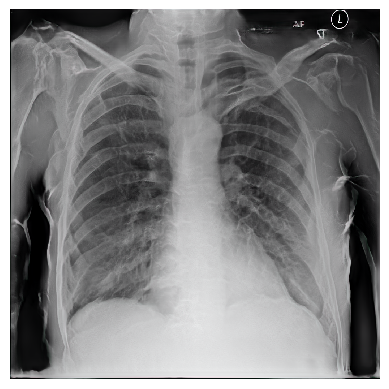

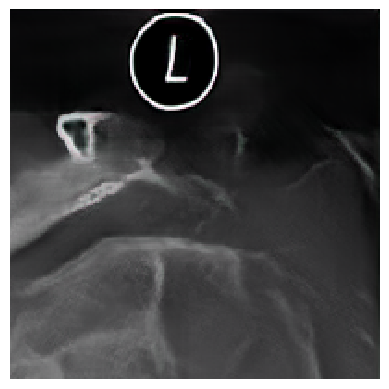

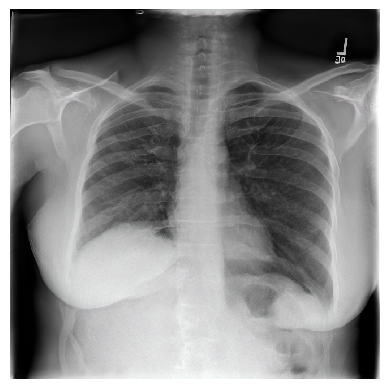

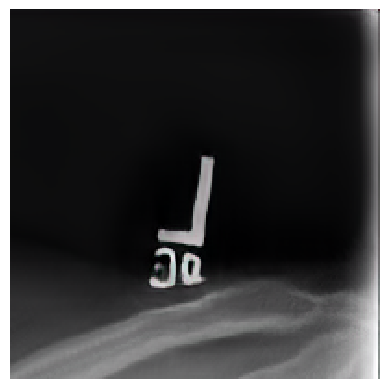

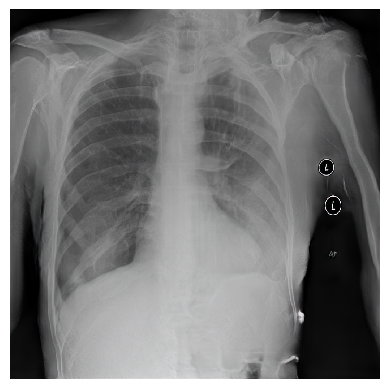

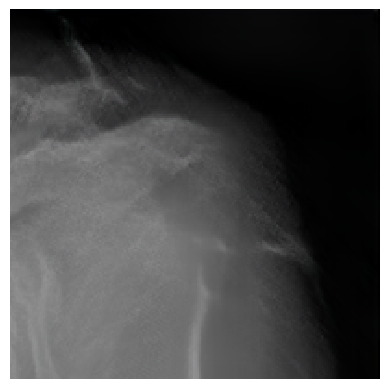

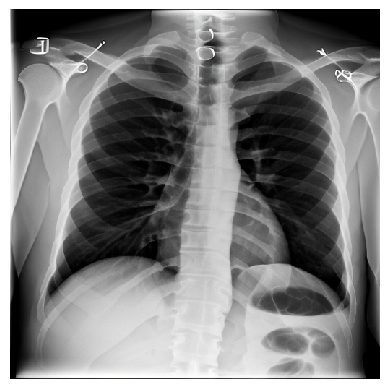

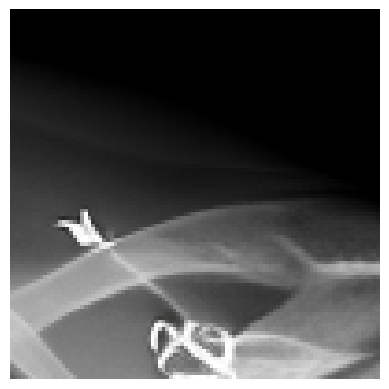

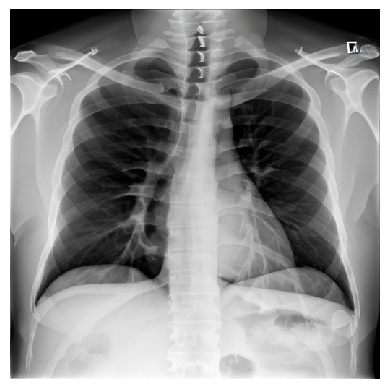

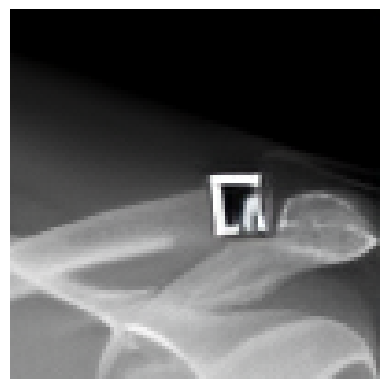

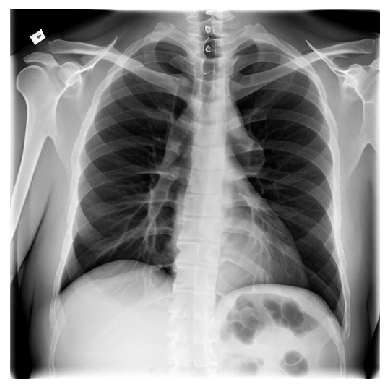

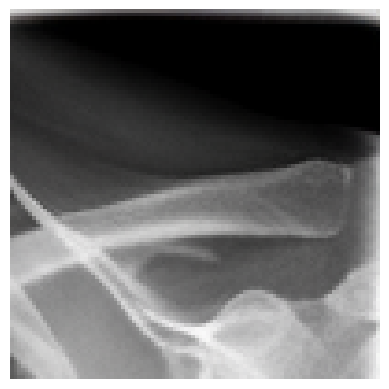

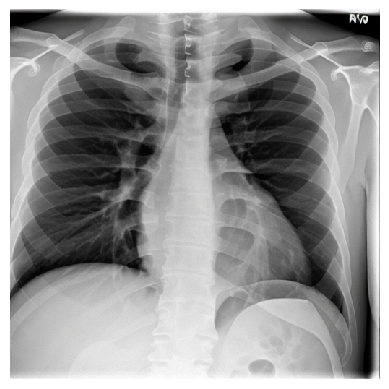

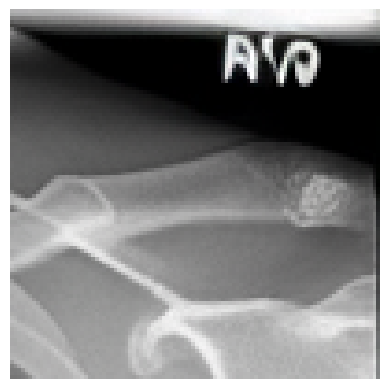

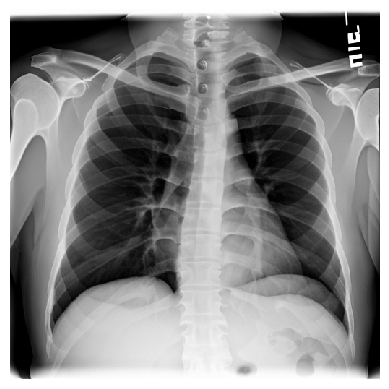

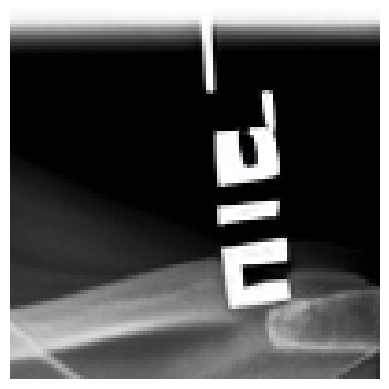

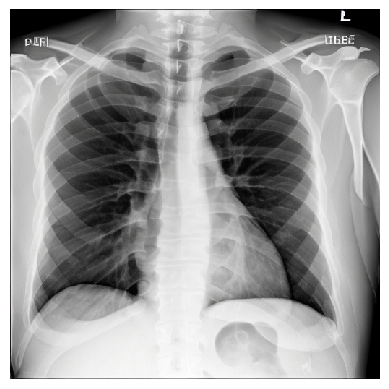

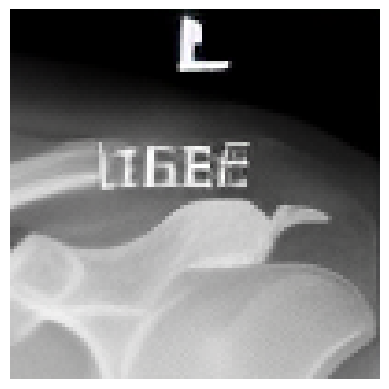

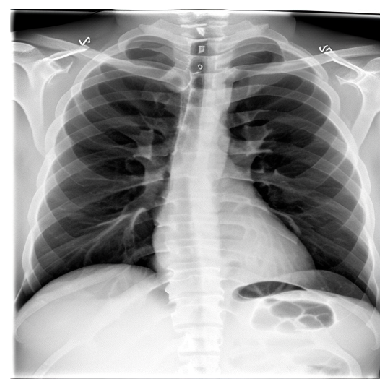

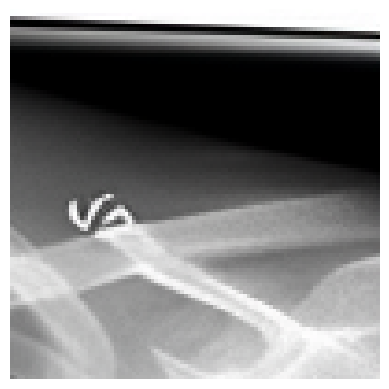

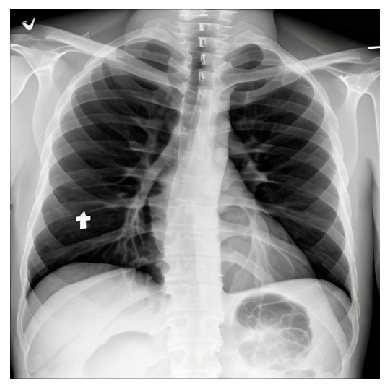

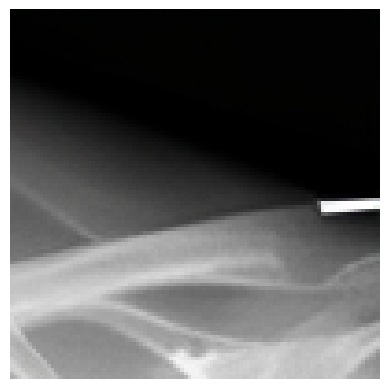

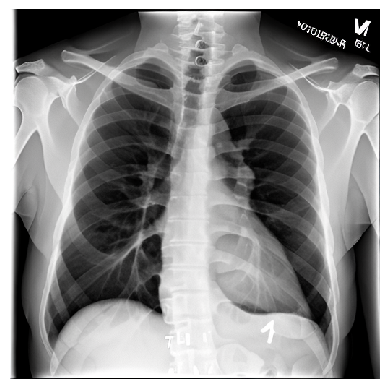

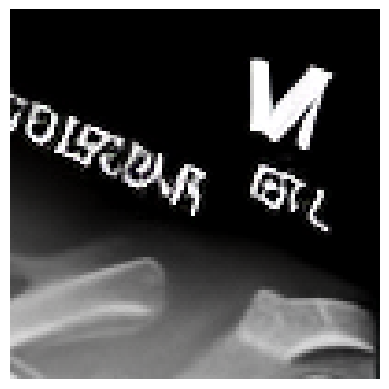

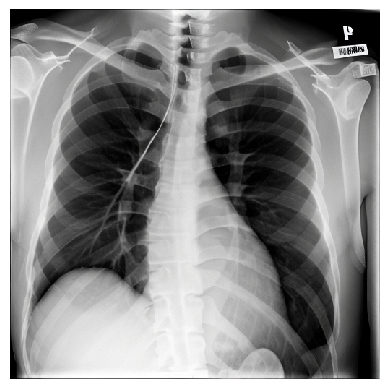

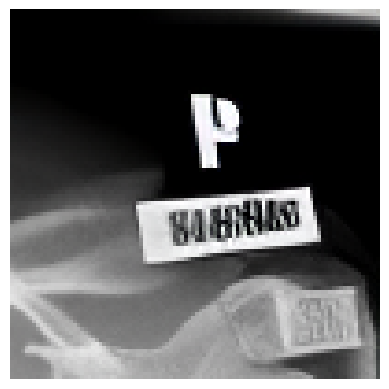

In [44]:
import os
import matplotlib.image as mpimg

real_path = Path('../../data/images')
sd_path = Path('../../data/output')
gan_path = Path('../../data/generated_samples')

np.random.seed(0)

dataset_id = "cxr"
n_examples = 10
def load_image(images_path, image_name):
    return mpimg.imread(os.path.join(images_path, image_name))

def load_random_image_from(path, random):
    images = list(path.iterdir())
    idx = random.choice(list(range(len(images))))
    return load_image(path, images[idx])


random = np.random.RandomState(42)
for i, dist in enumerate(["real", "PGGAN", "SD"]):
    for j in range(n_examples):
        fig, ax = plt.subplots()
        image = load_random_image_from(datasets[dataset_id]["paths"][dist],
                                       random)
        if image.max() > 1:
            image = image / 255.
            
        ax.imshow(image, cmap=plt.cm.binary_r)
        plotting.rm_spines(ax)
        
        fig.savefig(f"xray_{dist}_{j}.png", bbox_inches="tight", transparent=True, pad_inches=0)

        if image.shape[:2] == (512, 512):
            top_index = 100
        elif image.shape[:2] == (1024, 1024):
            top_index = 200
        else:
            raise AssertionError
        fig, ax = plt.subplots()
        ax.imshow(image[:top_index, -top_index:], cmap=plt.cm.binary_r)
        plotting.rm_spines(ax)

        fig.savefig(f"xray_{dist}_{j}_top.png", bbox_inches="tight", transparent=True, pad_inches=0)

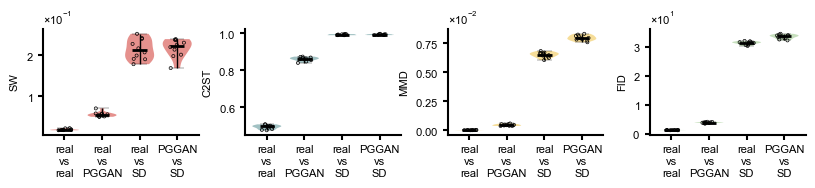

In [217]:
fig, axes = plt.subplot_mosaic(mosaic[2:4], figsize=cm2inch(25, 3.5))

# Set the formatter
formatter = ticker.ScalarFormatter(useMathText=True) # Use mathematical text for scientific notation
formatter.set_scientific(True) # Enable scientific notation
formatter.set_powerlimits((-1,1)) # This will force scientific notation

dataset_id = 'cxr'
experiment = experiments[dataset_id]
   

ylabels = ["SW", "C2ST", "MMD", "FID"]


for j, metric in enumerate(datasets[dataset_id]["metrics"]):
    for k, comparison in enumerate(datasets[dataset_id]["comparisons"]):
        X = tiled_ticks(0, 2, n_major_ticks=1, n_minor_ticks=len(datasets[dataset_id]["comparisons"]), offset=0.175)
        x, Y = X[0][k], experiment[j, k]
        ax = axes[metric.name]
        body_colors = generate_palette(color_dict[metrics_names[j]], n_colors=n_comparisons)
        place_violin(ax, x, Y, 
                        scatter_face_color="none",
                    scatter_edge_color="k",
                    scatter_lw=0.5,
                    scatter_radius=5,
                    scatter_alpha=1,
                    scatter_width=0.5,
                    scatter=True,
                    scatter_zorder=3,
                    width=0.09, 
                    median_color='k', #color_dict[metrics_names[i]],
                    median_bar_length=0.5, 
                    median_lw=2, 
                    whisker_color='k', #color_dict[metrics_names[i]],
                    whisker_alpha=1, 
                    whisker_lw=1,
                    median_alpha=1,
                    #    body_face_color=body_colors[k])
                    body_face_color=color_dict[metrics_names[j]],
                    body_edge_color="none",
                    body_alpha=0.5)

        ax.set_ylabel(ylabels[j])
        ax.yaxis.set_major_formatter(formatter)
        
        xticklabel = [xtl.split(" vs ") for xtl in datasets[dataset_id]["descr"]]
        xticklabel = ["\nvs\n".join(xtl) for xtl in xticklabel] 
        ax.set_xticks(X[0], xticklabel, rotation=0)

        ax.patch.set_alpha(0)

plt.subplots_adjust(wspace=0.425 * 2)
plt.savefig("application_01_cxr_v2_bottom_row.pdf", bbox_inches="tight", transparent=True)

In [220]:
!zip plots.zip *.pdf

updating: application_01_cxr.pdf (deflated 18%)
updating: application_01_cxr_v2_bottom_row.pdf (deflated 17%)
updating: application_01_cxr_v2_top_row.pdf (deflated 2%)
updating: application_01_ddm.pdf (deflated 18%)
updating: distances_violin.pdf (deflated 17%)
updating: figure_application_2_xray_examples.pdf (deflated 2%)
updating: gamma.pdf (deflated 31%)
updating: xray_PGGAN_1.pdf (deflated 0%)
updating: xray_PGGAN_2.pdf (deflated 0%)
updating: xray_PGGAN_3.pdf (deflated 0%)
updating: xray_PGGAN_4.pdf (deflated 0%)
updating: xray_real_1.pdf (deflated 2%)
updating: xray_real_2.pdf (deflated 2%)
updating: xray_real_3.pdf (deflated 2%)
updating: xray_real_4.pdf (deflated 2%)
updating: xray_SD_1.pdf (deflated 1%)
updating: xray_SD_2.pdf (deflated 2%)
updating: xray_SD_3.pdf (deflated 2%)
updating: xray_SD_4.pdf (deflated 2%)


In [72]:
!zip plots.zip application*.pdf

updating: application_01_cxr.pdf (deflated 18%)
updating: application_01_cxr_v2_bottom_row.pdf (deflated 17%)
updating: application_01_cxr_v2_top_row.pdf (deflated 2%)
updating: application_01_ddm.pdf (deflated 17%)
updating: application_01_cxr_wo_dist.pdf (deflated 18%)


In [45]:
!zip images.zip xray*.png

  adding: xray_PGGAN_0.png (deflated 0%)
  adding: xray_PGGAN_0_top.png (deflated 10%)
  adding: xray_PGGAN_1.png (deflated 0%)
  adding: xray_PGGAN_1_top.png (deflated 10%)
  adding: xray_PGGAN_2.png (deflated 0%)
  adding: xray_PGGAN_2_top.png (deflated 11%)
  adding: xray_PGGAN_3.png (deflated 0%)
  adding: xray_PGGAN_3_top.png (deflated 10%)
  adding: xray_PGGAN_4.png (deflated 0%)
  adding: xray_PGGAN_4_top.png (deflated 10%)
  adding: xray_PGGAN_5.png (deflated 0%)
  adding: xray_PGGAN_5_top.png (deflated 10%)
  adding: xray_PGGAN_6.png (deflated 0%)
  adding: xray_PGGAN_6_top.png (deflated 11%)
  adding: xray_PGGAN_7.png (deflated 0%)
  adding: xray_PGGAN_7_top.png (deflated 8%)
  adding: xray_PGGAN_8.png (deflated 0%)
  adding: xray_PGGAN_8_top.png (deflated 10%)
  adding: xray_PGGAN_9.png (deflated 0%)
  adding: xray_PGGAN_9_top.png (deflated 10%)
  adding: xray_real_0.png (deflated 3%)
  adding: xray_real_0_top.png (deflated 37%)
  adding: xray_real_1.png (deflated 3%)
  addi